<a href="https://colab.research.google.com/github/antoinebachand/Deep-Learnig-/blob/main/Copie_de_DL_Assignment_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

By: Antoine Bachand & Edouard Virot & Jurriaan Simon Berger

> Bloc en retrait




# Some logistics
Setting up stuff in Colab

In [144]:
from google.colab import drive

ROOT = '/content/drive'
drive.mount(ROOT)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [145]:
from os.path import join
PROJ = 'MyDrive/Deep Learning/Assignment'
PROJ_PATH = join(ROOT, PROJ)

In [146]:
!rsync -aP "{PROJ_PATH}"/* ./

sending incremental file list


In [279]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn.functional as functional
import torch.nn as nn

In [280]:
import matplotlib.pyplot as plt
%matplotlib inline

# Loading data

Note that the data has been edited already a bit. We created a table that has one 'vector' per company per day. To the vector the sector information and expert judgement have been added. We also did a few data translations: 

*   Creating a one-hot encoding for the company. Instead of using 0/1/2, where the number is only categorical and does not represent a value.
*   Calculating the *Y* values, the values that we need to predict. True for an increase, false for constant or decrease.

In this section we will do some more data cleaning and standardization. These steps will be added to the predictor.py file that we hand in. To make sure that the same model can be used by that program, with the similar formatting of the inputs.
This also holds for the editing that has been done outside of this notebook.


In [340]:
#load the data
df = pd.read_csv('data.csv')

In [341]:
#inspect if everything is OK
df.head()


,company,year,day,quarter,expert1,expert2,sentiment,m1,m2,m3,m4,company0,company1,company2,segment,trend,stock-price,price increase
0,0,2017,3,0,0,0,10,6.3,1824.0,-1.0,0,1,0,0,1,0,102.2,0
1,0,2017,4,0,0,1,10,5.1,6912.0,-0.9,0,1,0,0,1,0,102.2,0
2,0,2017,5,0,0,1,10,6.6,8928.0,0.3,0,1,0,0,1,0,102.2,0
3,0,2017,6,0,0,1,10,7.8,6924.0,0.0,0,1,0,0,1,0,102.2,0
4,0,2017,9,0,0,1,10,-0.9,5635.0,0.9,0,1,0,0,1,0,102.2,0


In [342]:
# TODO
# Get rid of columns that we do not want to use
# Normalization



*   Drop the column 'company' > this information is available in the one-hot encoding
*   Drop the column with the year, day and quarter. This is 'categorical' data/time series, for which the model cannot account.



In [343]:
# TODO:
# Quarter could maybe work, day very very maybe
# Perhaps change it in day of the week (with one-hot encoding)

df_drop = df.drop(['company','year','day','quarter'],axis=1)

In [344]:
df_drop.head()

,expert1,expert2,sentiment,m1,m2,m3,m4,company0,company1,company2,segment,trend,stock-price,price increase
0,0,0,10,6.3,1824.0,-1.0,0,1,0,0,1,0,102.2,0
1,0,1,10,5.1,6912.0,-0.9,0,1,0,0,1,0,102.2,0
2,0,1,10,6.6,8928.0,0.3,0,1,0,0,1,0,102.2,0
3,0,1,10,7.8,6924.0,0.0,0,1,0,0,1,0,102.2,0
4,0,1,10,-0.9,5635.0,0.9,0,1,0,0,1,0,102.2,0


*    Scale all columns 0 to 1

In [345]:
# TODO:
# Does this scaling work properly?
# How to make sure that the same scaling is applied in the final model?

# Look into: https://scikit-learn.org/stable/modules/preprocessing.html#scaling-features-to-a-range 

# Using normalization, as the data does not follow a Gaussian distribution. Also we use a NN. From: https://www.analyticsvidhya.com/blog/2020/04/feature-scaling-machine-learning-normalization-standardization/ 

norm = MinMaxScaler().fit(df_drop) # In the example, Xtrain is the input for this; only fit it on the correct columns
nd_norm = norm.transform(df_drop)
df_norm = pd.DataFrame(nd_norm)
df_norm.columns = ['expert1', 'expert2', 'sentiment', 'm1','m2', 'm3', 'm4', 'company0', 'company1', 'company2', 'segment', 'trend', 'stock-price', 'price increase']

# Not used now, note that the one-hot encoding columns and price increase should be treated apart.
scaler = StandardScaler().fit(df_drop)
nd_scaled = scaler.transform(df_drop)
df_scaled = pd.DataFrame(nd_scaled)


In [346]:
df_norm.describe()

,expert1,expert2,sentiment,m1,m2,m3,m4,company0,company1,company2,segment,trend,stock-price,price increase
count,1878.000000,1878.000000,1878.000000,1878.000000,1878.000000,1878.000000,1878.000000,1878.000000,1878.000000,1878.000000,1878.000000,1878.000000,1878.000000,1878.000000
mean,0.202343,0.237487,0.341267,0.497734,0.499228,0.508413,0.053248,0.333333,0.333333,0.333333,0.666667,0.412939,0.555296,0.338658
std,0.401854,0.425656,0.325503,0.286360,0.291111,0.297416,0.224588,0.471530,0.471530,0.471530,0.471530,0.399797,0.331809,0.473379
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.100000,0.245000,0.241095,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.263150,0.000000
50%,0.000000,0.000000,0.200000,0.500000,0.499700,0.500000,0.000000,0.000000,0.000000,0.000000,1.000000,0.500000,0.649711,0.000000
75%,0.000000,0.000000,0.600000,0.748750,0.754928,0.750000,0.000000,1.000000,1.000000,1.000000,1.000000,0.500000,0.850723,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Prepare data for training/testing

Split the data in a training and test set. It is important that this is done randomly, as the data is divided per company (the first 1/3rd of the rows are only about company 0). Sklearn takes care of this in the method `train_test_split`.

In [347]:
#split training in training and test data
columns = df_norm.columns.values.tolist()
independent = columns[:-1]
dependent = columns[-1]

X_train, X_test, y_train, y_test = train_test_split(df_norm[independent],df_norm[dependent], test_size=0.2)

In [348]:
BATCH_SIZE = 32
X = torch.tensor(X_train.values, dtype=torch.float)
y = torch.tensor(y_train.values, dtype=torch.int64)

train_ds = torch.utils.data.TensorDataset(X,y)

X = torch.tensor(X_test.values, dtype=torch.float)
y = torch.tensor(y_test.values, dtype=torch.int64)

test_ds = torch.utils.data.TensorDataset(X,y)

In [349]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE,shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

# Building the network

Yes, this is what it is about

In [350]:
# Build the network
class stockANN(nn.Module):

  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(13,32)
    self.av1 = nn.ReLU()

    self.fc2 = nn.Linear(32,32) 
    self.fc2_bn = nn.BatchNorm1d(32)
    #self.fc2_dp = nn.Dropout(p=0.2)
    self.av2 = nn.ReLU()

    self.fc3 = nn.Linear(32,32)
    self.fc3_bn = nn.BatchNorm1d(32)
    #self.fc3_dp = nn.Dropout(p=0.2)
    self.av3 = nn.ReLU()

    self.fc4 = nn.Linear(32,32)
    self.fc4_bn = nn.BatchNorm1d(32)
    self.av4 = nn.ReLU()

    self.out = nn.Linear(32,1)
    self.out_act = nn.Sigmoid()
    return
  
  def forward(self,x):
    x = self.fc1(x)
    x = self.av1(x)

    x = self.fc2(x)
    x = self.fc2_bn(x)
    #x = self.fc2_dp(x)
    x = self.av2(x)

    x = self.fc3(x)
    x = self.fc3_bn(x)
    #x = self.fc2_dp(x)
    x = self.av3(x)

    x = self.fc4(x)
    x = self.fc4_bn(x)
    x = self.av4(x)

    x = self.out(x)
    y = self.out_act(x)
    return y

net = stockANN()
print(net)

stockANN(
  (fc1): Linear(in_features=13, out_features=32, bias=True)
  (av1): ReLU()
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc2_bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2_dp): Dropout(p=0.2, inplace=False)
  (av2): ReLU()
  (fc3): Linear(in_features=32, out_features=32, bias=True)
  (fc3_bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (av3): ReLU()
  (fc4): Linear(in_features=32, out_features=32, bias=True)
  (fc4_bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (av4): ReLU()
  (out): Linear(in_features=32, out_features=1, bias=True)
  (out_act): Sigmoid()
)


# Training the network

Train the deep learning network, this code is re-used from the labs.

The loss function is changed to accomodate for the binary output.

In [351]:
# Train the network.

# Note that you would first need to run the test code cells below

def train():
  
  criterion = nn.BCELoss()

  training_acc = []
  test_acc = []
  loss_table = []

  optimizer = torch.optim.Adam(net.parameters(), lr=0.0005)
  for epocs in range(300):
    losses = []
    for data in train_dl:
      X, y = data
      optimizer.zero_grad() # Clear the gradients, before next batch.
      output = net(X.view(-1,13))  # Forward pass
    
      y = y.unsqueeze(1) #                                          >>> THIS SOLVED THE ISSUE BELOW, SEEMS A BIT DIRTY <<<
      y = y.float()
    
      loss = criterion(output, y) # Computing loss.                  >>> STUCK HERE, TENSOR DIMENSIONS <<<
    
      loss.backward()  # Back-propagation (computing gradients)
    
      losses.append(loss.data.numpy()) # For making the plot
    
      optimizer.step(); # Update the weights (using gradients). 
      # TODO, look at this indent, do you want to update the weights after every datapoint?

    print('LOSS 1:',sum(losses)/len(losses))
    print('LOSS 2:    ',loss.data)
    print('TEST:    ',test_accuracy())
    print('TRAINING:',training_accuracy())

    test_acc+=[test_accuracy()]
    training_acc+=[training_accuracy()]
    loss_table+=[sum(losses)/len(losses)]

  #print(e_losses,t_losses)
  return training_acc,test_acc,loss_table


In [355]:
train_acc,test_acc,train_loss = train()

LOSS 1: 0.4863423413418709
LOSS 2:     tensor(0.4932)
TEST:     0.809
TRAINING: 0.838
LOSS 1: 0.4078807875196985
LOSS 2:     tensor(0.4220)
TEST:     0.835
TRAINING: 0.861
LOSS 1: 0.3614504229515157
LOSS 2:     tensor(0.3352)
TEST:     0.822
TRAINING: 0.861
LOSS 1: 0.3424724283370566
LOSS 2:     tensor(0.2950)
TEST:     0.822
TRAINING: 0.858
LOSS 1: 0.3290794076437646
LOSS 2:     tensor(0.2327)
TEST:     0.83
TRAINING: 0.858
LOSS 1: 0.32824701958514274
LOSS 2:     tensor(0.2815)
TEST:     0.851
TRAINING: 0.87
LOSS 1: 0.321297139880505
LOSS 2:     tensor(0.3364)
TEST:     0.835
TRAINING: 0.862
LOSS 1: 0.3111469396885405
LOSS 2:     tensor(0.2800)
TEST:     0.835
TRAINING: 0.871
LOSS 1: 0.3072702231559348
LOSS 2:     tensor(0.3118)
TEST:     0.843
TRAINING: 0.874
LOSS 1: 0.3048457202125103
LOSS 2:     tensor(0.2704)
TEST:     0.838
TRAINING: 0.867
LOSS 1: 0.2961019017594926
LOSS 2:     tensor(0.1874)
TEST:     0.835
TRAINING: 0.864
LOSS 1: 0.2993120310154367
LOSS 2:     tensor(0.2805)
TE

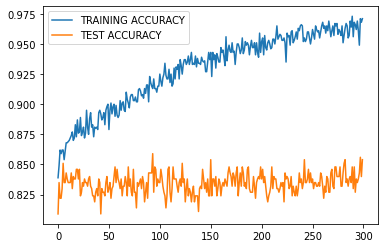

In [356]:
plt.plot(train_acc, label='TRAINING ACCURACY')
plt.plot(test_acc, label='TEST ACCURACY')
plt.legend()

In [ ]:
plt.plot(train_loss)

# Testing the network

Check the result on the test data, this code is re-used from the labs. But adapted to deal with the binary output.

In [353]:
# Evaluate the trained network.

def test_accuracy():
  total = 0
  correct = 0
  with torch.no_grad():   # No need for keepnig track of necessary changes to the gradient.
    for data in test_dl:
      X, y = data
      output = net(X.view(-1,13))
    
      for idx, val in enumerate(output):    
      
        prediction = val.item()
        if prediction < 0.5: prediction = 0
        else: prediction = 1

      # print('RESULT: ',prediction,y[idx].item())

        if prediction == y[idx].item():
          correct += 1
      
        total += 1
    # print('Accuracy:', round(correct/total, 3))

  return round(correct/total, 3)

In [332]:
test_accuracy()

0.625

In [354]:
def training_accuracy():
  total = 0
  correct = 0
  with torch.no_grad():   # No need for keepnig track of necessary changes to the gradient.
    for data in train_dl:
      X, y = data
      output = net(X.view(-1,13))
    
      for idx, val in enumerate(output):    
      
        prediction = val.item()
        if prediction < 0.5: prediction = 0
        else: prediction = 1

      # print('RESULT: ',prediction,y[idx].item())

        if prediction == y[idx].item():
          correct += 1
      
        total += 1
    # print('Accuracy:', round(correct/total, 3))

  return round(correct/total, 3)

## Test results

Some comments on the different network architectures that we built and tested, what was good and what was bad. Also on the learning parameters.

# Exporting the network
Here we store the trained network, now it can be deployed in the predictor class.